In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
MAX_TIMESTAMP = 1341705593

In [4]:
g = nx.DiGraph()

In [3]:
with open("data/higgs-social_network.edgelist") as file:
  for line in file:
    v, u = line.strip('\n').split(" ")
    g.add_edge(v, u)

In [32]:
connected_comp = list(nx.strongly_connected_components(g))

In [33]:
maximum = 0
maximum_element = {}
for element in connected_comp:
  if len(element) > maximum:
    maximum = len(element)
    maximum_element = element

In [21]:
with open("data/higgs-mention_network.edgelist", "r") as file:
  with open("data/higgs-mention_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [22]:
with open("data/higgs-reply_network.edgelist", "r") as file:
  with open("data/higgs-reply_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [23]:
with open("data/higgs-retweet_network.edgelist", "r") as file:
  with open("data/higgs-retweet_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [52]:
with open("data/higgs-social_network.edgelist", "r") as file:
  with open("data/higgs-social_network_filtered.edgelist", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      items[1] = items[1][:-1]
      if items[0] in maximum_element and items[1] in maximum_element:
        filtered_file.write(line)

In [25]:
with open("data/higgs-activity_time.txt", "r") as file:
  with open("data/higgs-activity_time_filtered.txt", "w") as filtered_file:
    for line in file:
      items = line.split(" ")
      if items[0] in maximum_element and items[1] in maximum_element:
          filtered_file.write(line)

In [5]:
g = nx.DiGraph()

In [6]:
with open("data/higgs-social_network_filtered.edgelist") as file:
  for line in file:
    v, u = line.strip('\n').split(" ")
    g.add_edge(v, u)

In [7]:
n = len(g.nodes)
e = len(g.edges)
average_degree = e / n

In [8]:
print("Grado promedio {}".format(average_degree))

Grado promedio 39.15106465672802


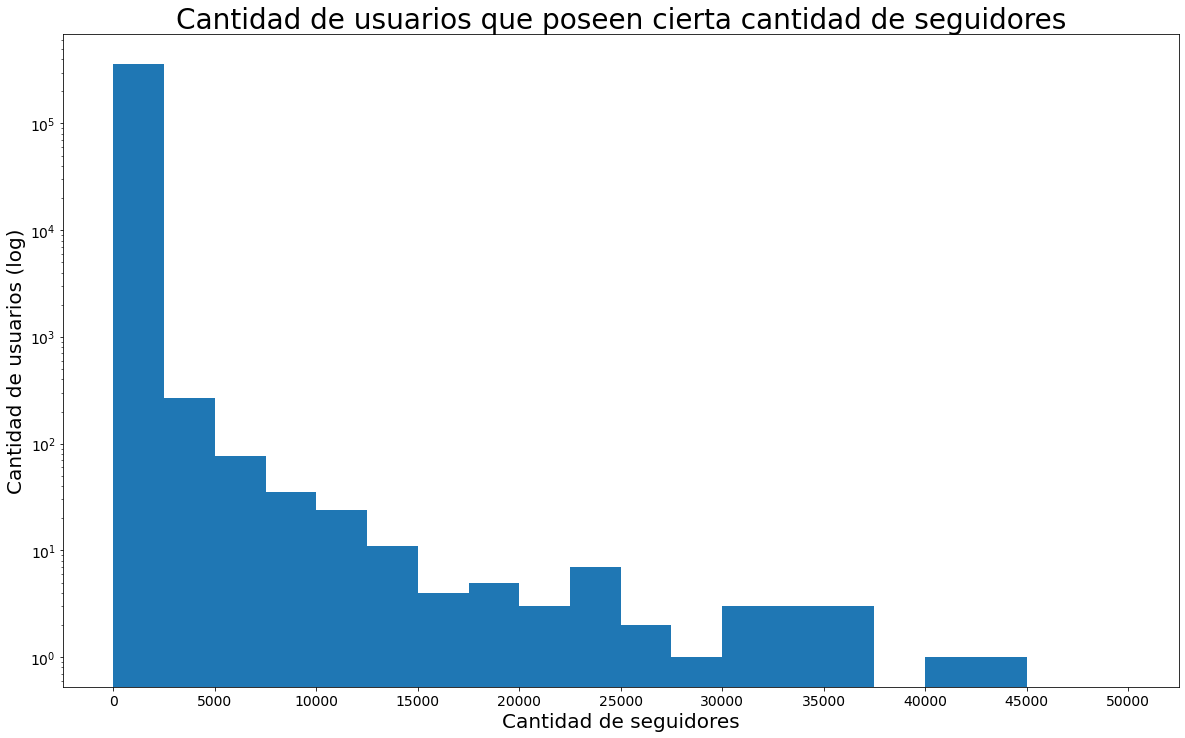

In [9]:
degrees = dict(g.in_degree)
bins = np.arange(-0.5, 51000, 2500)

plt.figure(figsize=(20,12))
plt.hist(list(degrees.values()), bins=bins, log=True)
plt.xlabel("Cantidad de seguidores", size=20)
plt.ylabel("Cantidad de usuarios (log)", size=20)
plt.xticks(range(0, 55000, 5000), fontsize=14)
plt.yticks(fontsize=14)
plt.title("Cantidad de usuarios que poseen cierta cantidad de seguidores", fontsize=28)

plt.show()

In [10]:
g_undirected = nx.Graph()

In [11]:
with open("data/higgs-social_network_filtered.edgelist") as file:
  for line in file:
    v, u = line.strip('\n').split(" ")
    g_undirected.add_edge(v, u)

In [12]:
def frontier_sampling(g, n_seeds=10, budget=1000):
  nodes = list(g.nodes())
  edges = list(g.edges())
  if len(nodes) < n_seeds:
    raise ValueError("Not enough nodes")
  seeds = []
  degrees = []
  while len(seeds) < n_seeds:
    seed = random.choice(nodes)
    if seed not in seeds:
      seeds.append(seed)
      
  for seed in seeds:
    degrees.append(g.degree(seed))
  
  used_budget = 0
  new_g = nx.DiGraph()
  
  while used_budget < budget:
    random_n = np.random.uniform(0, 1)
    summation = 0
    index = 0
    total_degree = sum(degrees)
    
    while summation < random_n:
      summation += degrees[index] / total_degree
      index += 1

    index -= 1
    
    v = seeds[index]
    u = random.choice(list(g.neighbors(v)))
    degrees[index] = g.degree(v)
    new_g.add_edge(v, u)
    
    #print("index: {}, v: {}, u: {}".format(index, v, u))
    #print("seeds: ", seeds)
    
    seeds[index] = u
    used_budget += 1
    
  return new_g

In [13]:
new_g = frontier_sampling(g_undirected, 100, 4500000)

In [14]:
len(new_g.nodes())

323707

In [15]:
len(new_g.edges())

4094649

In [16]:
len(g.nodes())

360210

In [17]:
len(g.edges())

14102605

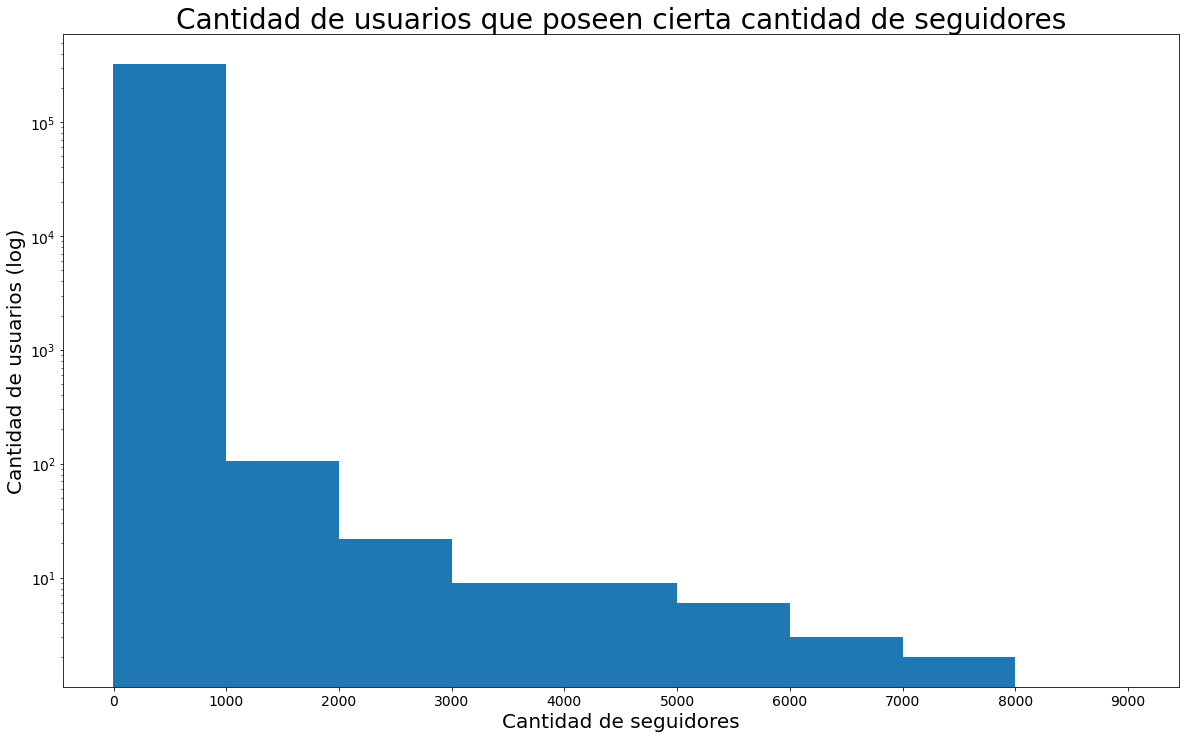

In [18]:
degrees = dict(new_g.in_degree)
bins = np.arange(-0.5, 9001, 1000)

plt.figure(figsize=(20,12))
plt.hist(list(degrees.values()), bins=bins, log=True)
plt.xlabel("Cantidad de seguidores", size=20)
plt.ylabel("Cantidad de usuarios (log)", size=20)
plt.xticks(range(0, 9001, 1000), fontsize=14)
plt.yticks(fontsize=14)
plt.title("Cantidad de usuarios que poseen cierta cantidad de seguidores", fontsize=28)

plt.show()

### Clustering

In [19]:
nx.average_clustering(new_g)

0.03257261747245524

In [20]:
activity_g = nx.DiGraph()

In [21]:
with open("data/higgs-activity_time_filtered.txt") as file:
  for line in file:
    v, u, timestamp, interaction = line.strip('\n').split(" ")
    activity_g.add_edge(v, u, interaction=interaction, timestamp=timestamp)

In [22]:
len(activity_g.nodes())

247861

In [23]:
len(activity_g.edges())

394197

In [24]:
retweets = 0
retweets_followers = 0
retweets_mutual = 0
mentions = 0
mentions_followers = 0
mentions_mutual = 0
responses = 0
responses_followers = 0
responses_mutual = 0

for e in activity_g.edges():
  u, v = e
  activity = activity_g.get_edge_data(u, v)["interaction"]
  if activity == "RT":
    retweets += 1
    if g.has_edge(u, v):
      retweets_followers += 1
      if g.has_edge(v, u):
        retweets_mutual += 1
  elif activity == "MT":
    mentions += 1
    if g.has_edge(u, v):
      mentions_followers += 1
      if g.has_edge(v, u):
        mentions_mutual += 1
  elif activity == "RE":
    responses += 1
    if g.has_edge(u, v):
      responses_followers += 1
      if g.has_edge(v, u):
        responses_mutual += 1

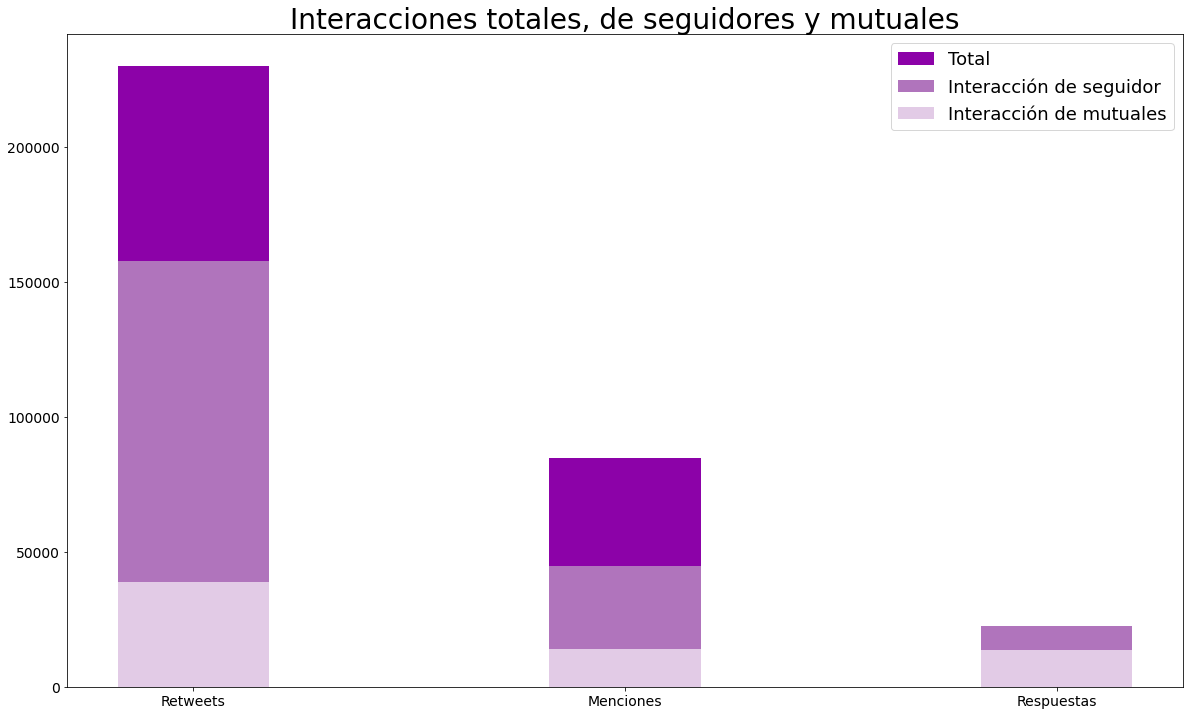

In [25]:
labels = ["Retweets", "Menciones", "Respuestas"]
activity_without_followers = [retweets - retweets_followers, mentions - mentions_followers, responses - responses_followers]
activity_with_followers = [retweets_followers - retweets_mutual, mentions_followers - mentions_mutual, responses_followers - responses_mutual]
activity_mutuals = [retweets_mutual, mentions_mutual, responses_mutual]
width = 0.35

plt.figure(figsize=(20,12))
plt.bar(labels, activity_without_followers, width, bottom=activity_with_followers, label='Total', color="#8C02A8")
plt.bar(labels, activity_with_followers, width, bottom=activity_mutuals, label='Interacción de seguidor', color="#B074BC")
plt.bar(labels, activity_mutuals, width, label='Interacción de mutuales', color="#e2cbe6")

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=18)
plt.title("Interacciones totales, de seguidores y mutuales", fontsize=28)

plt.show()

In [26]:
retweets_timestamps = []
mentions_timestamps = []
responses_timestamps = []

In [27]:
def get_relative_timestamp(abs_timestamp):
  initial_timelapse = 1341100972
  final_timelapse = 1341705593
  duration = final_timelapse - initial_timelapse

  return (int(abs_timestamp) - initial_timelapse) / duration

In [28]:
with open("data/higgs-activity_time_filtered.txt") as file:
  for line in file:
    v, u, timestamp, interaction = line.strip('\n').split(" ")
    relative_timestamp = get_relative_timestamp(timestamp)
    if interaction == "RT":
      retweets_timestamps.append(relative_timestamp)
    elif interaction == "MT":
      mentions_timestamps.append(relative_timestamp)
    elif interaction == "RE":
      responses_timestamps.append(relative_timestamp)

In [29]:
def acummulated_interactions(interactions_timestamps, steps):
  interactions_acum = []
  index = 0
  summation = 0
  
  for i in range(steps):
    while interactions_timestamps[index] < i / steps:
      index += 1
    interactions_acum.append(index)
    
  return interactions_acum

In [30]:
def get_interaction_maximum_users(users_g, interactions_g, interaction_type, top_users=10):
  MAX_TIMESTAMP = 1341705593
  degrees = dict(users_g.in_degree())
  users_interaction = []
  while len(users_interaction) < top_users:
    user = max(degrees, key=degrees.get)
    minimum_timestamp = MAX_TIMESTAMP + 1
    for u, v in list(interactions_g.out_edges(user)):
      edge_data = interactions_g.get_edge_data(u, v)
      if edge_data["interaction"] == interaction_type:
        new_timestamp = int(edge_data["timestamp"])
        if new_timestamp < minimum_timestamp:
          minimum_timestamp = new_timestamp
        
    if minimum_timestamp <= MAX_TIMESTAMP:  
      users_interaction.append(get_relative_timestamp(minimum_timestamp))
      
    degrees.pop(user)

  return users_interaction

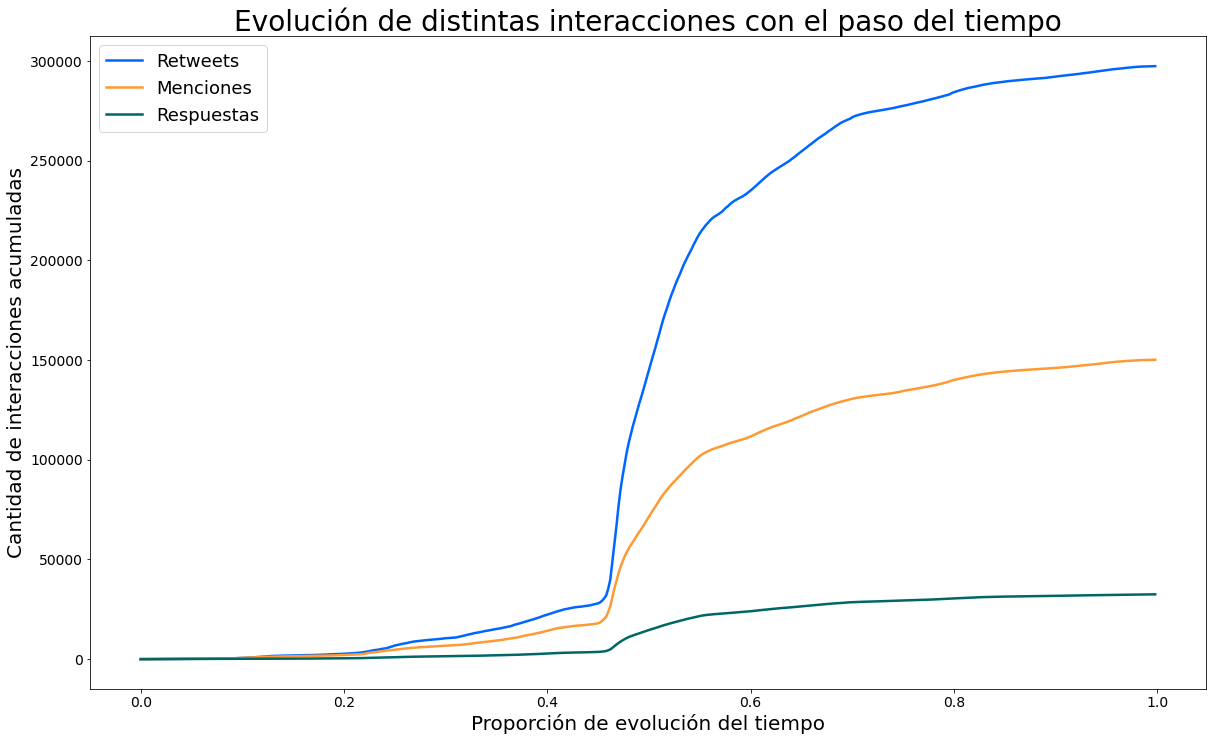

In [31]:
steps = 500
x_values = np.arange(0, 1, 1/steps)

retweets_acum = acummulated_interactions(retweets_timestamps, steps)
mentions_acum = acummulated_interactions(mentions_timestamps, steps)
responses_acum = acummulated_interactions(responses_timestamps, steps)

plt.figure(figsize=(20,12))
plt.plot(x_values, retweets_acum, label='Retweets', color="#0066ff", lw=2.5)
plt.plot(x_values, mentions_acum, label='Menciones', color="#ff9933", lw=2.5)
plt.plot(x_values, responses_acum, label='Respuestas', color="#006666", lw=2.5)
plt.xlabel("Proporción de evolución del tiempo", size=20)
plt.ylabel("Cantidad de interacciones acumuladas", size=20)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=18)
plt.title("Evolución de distintas interacciones con el paso del tiempo", fontsize=28);

In [32]:
def get_y_value(x_values, y_values, values):
  resulted_y_values = []
  for value in values:
    i = 0
    while value > x_values[i]:
      i += 1
    resulted_y_values.append(y_values[i])
  return resulted_y_values

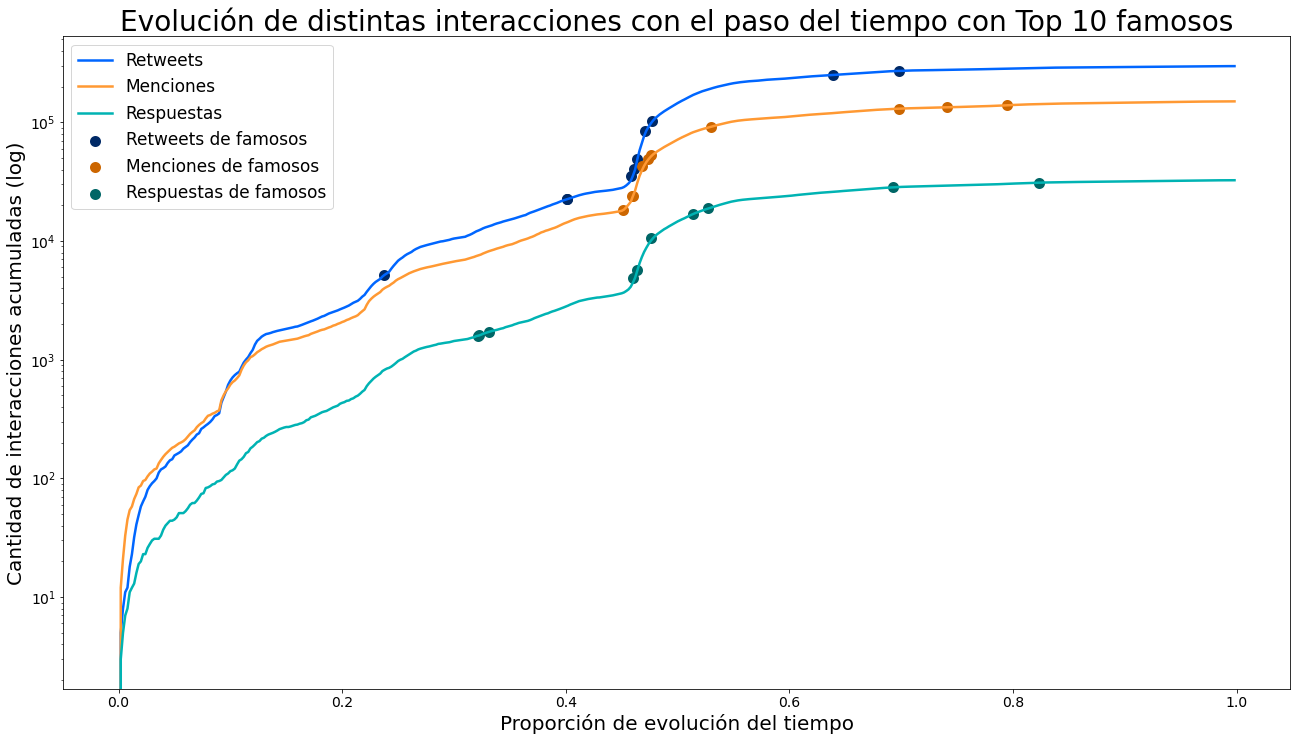

In [33]:
steps = 500
x_values = np.arange(0, 1, 1/steps)

retweets_acum = acummulated_interactions(retweets_timestamps, steps)
mentions_acum = acummulated_interactions(mentions_timestamps, steps)
responses_acum = acummulated_interactions(responses_timestamps, steps)

retweets_famous = get_interaction_maximum_users(g, activity_g, "RT", 10)
retweets_famous_y = get_y_value(x_values, retweets_acum, retweets_famous)
mentions_famous = get_interaction_maximum_users(g, activity_g, "MT", 10)
mentions_famous_y = get_y_value(x_values, mentions_acum, mentions_famous)
responses_famous = get_interaction_maximum_users(g, activity_g, "RE", 10)
responses_famous_y = get_y_value(x_values, responses_acum, responses_famous)

plt.figure(figsize=(22,12))
plt.yscale("log")
plt.plot(x_values, retweets_acum, label='Retweets', color="#0066ff", lw=2.5)
plt.plot(x_values, mentions_acum, label='Menciones', color="#ff9933", lw=2.5)
plt.plot(x_values, responses_acum, label='Respuestas', color="#00b3b3", lw=2.5)
plt.scatter(retweets_famous, retweets_famous_y, label='Retweets de famosos', color="#002966", lw=5)
plt.scatter(mentions_famous, mentions_famous_y, label='Menciones de famosos', color="#cc6600", lw=5)
plt.scatter(responses_famous, responses_famous_y, label='Respuestas de famosos', color="#006666", lw=5)

plt.xlabel("Proporción de evolución del tiempo", size=20)
plt.ylabel("Cantidad de interacciones acumuladas (log)", size=20)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=17)
plt.title("Evolución de distintas interacciones con el paso del tiempo con Top 10 famosos", fontsize=28);

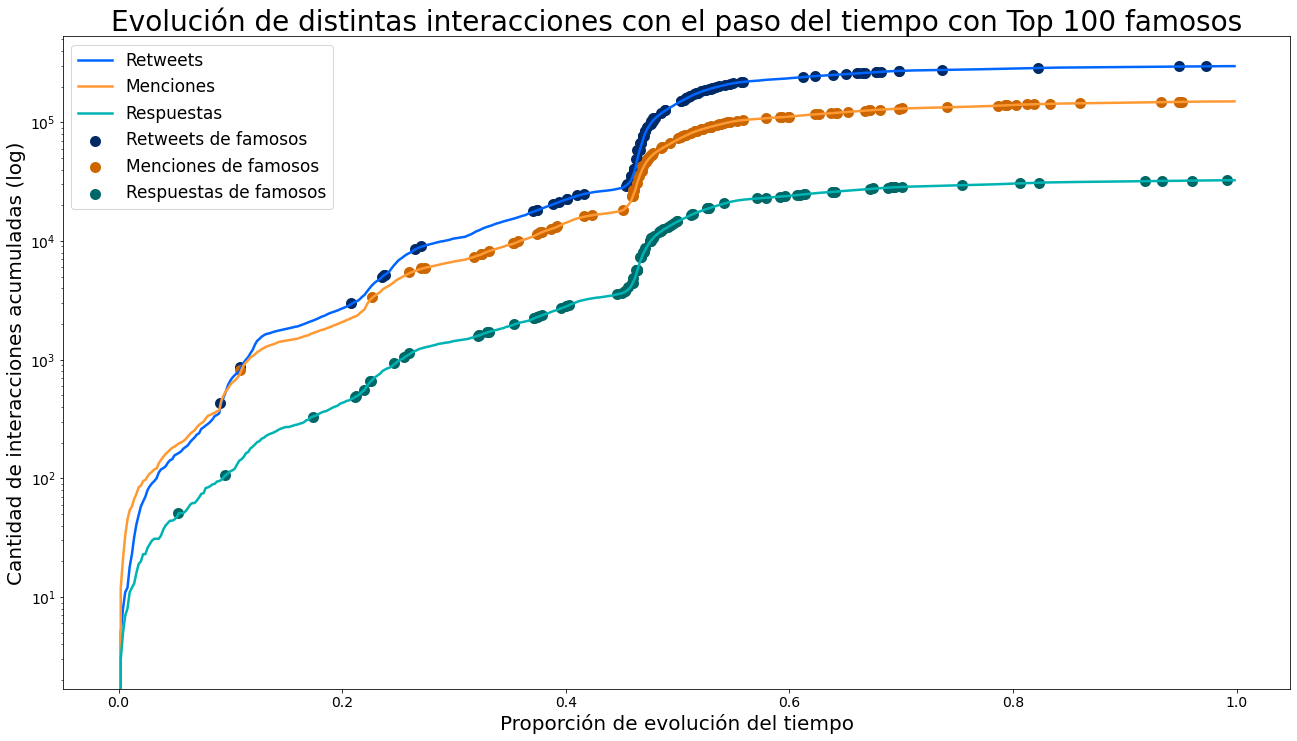

In [34]:
steps = 500
x_values = np.arange(0, 1, 1/steps)

retweets_acum = acummulated_interactions(retweets_timestamps, steps)
mentions_acum = acummulated_interactions(mentions_timestamps, steps)
responses_acum = acummulated_interactions(responses_timestamps, steps)

retweets_famous = get_interaction_maximum_users(g, activity_g, "RT", 100)
retweets_famous_y = get_y_value(x_values, retweets_acum, retweets_famous)
mentions_famous = get_interaction_maximum_users(g, activity_g, "MT", 100)
mentions_famous_y = get_y_value(x_values, mentions_acum, mentions_famous)
responses_famous = get_interaction_maximum_users(g, activity_g, "RE", 100)
responses_famous_y = get_y_value(x_values, responses_acum, responses_famous)

plt.figure(figsize=(22,12))
plt.yscale("log")
plt.plot(x_values, retweets_acum, label='Retweets', color="#0066ff", lw=2.5)
plt.plot(x_values, mentions_acum, label='Menciones', color="#ff9933", lw=2.5)
plt.plot(x_values, responses_acum, label='Respuestas', color="#00b3b3", lw=2.5)
plt.scatter(retweets_famous, retweets_famous_y, label='Retweets de famosos', color="#002966", lw=5)
plt.scatter(mentions_famous, mentions_famous_y, label='Menciones de famosos', color="#cc6600", lw=5)
plt.scatter(responses_famous, responses_famous_y, label='Respuestas de famosos', color="#006666", lw=5)

plt.xlabel("Proporción de evolución del tiempo", size=20)
plt.ylabel("Cantidad de interacciones acumuladas (log)", size=20)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=17)
plt.title("Evolución de distintas interacciones con el paso del tiempo con Top 100 famosos", fontsize=28);

In [43]:
def get_activation_percentage_list(activity_g, followers_g):
  percentages = []
  len_nodes = len(activity_g.nodes())
  countdown = 1
  for v in activity_g.nodes():
    min_timestamp = MAX_TIMESTAMP
    k_activated = 0
    
    for u in activity_g.successors(v):
      #print(v)
      #print(activity_g.get_edge_data(u, v))
      #print(activity_g.get_edge_data(v, u))
      timestamp = int(activity_g.get_edge_data(v, u)["timestamp"])
      #return
      if timestamp < min_timestamp:
        min_timestamp = timestamp
    for u in followers_g.successors(v):
      min_local_timestamp = MAX_TIMESTAMP
      if u in activity_g.nodes():
        for w in activity_g.successors(u):
          timestamp = activity_g.get_edge_data(u, w)
          if timestamp is not None:
            timestamp = int(activity_g.get_edge_data(u, w)["timestamp"])
            if timestamp < min_local_timestamp:
              min_local_timestamp = timestamp
        if min_local_timestamp < min_timestamp:
          k_activated += 1
    
    k_total = len(followers_g.out_edges(v))
    if k_total != 0:
      percentages.append(round(k_activated / k_total, 1))
      
    countdown += 1 
    if countdown % 20000 == 0:
      print(countdown)
  
  return percentages

In [44]:
activation_percentages = get_activation_percentage_list(activity_g, g)

20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000


In [60]:
0.5 in activation_percentages

True

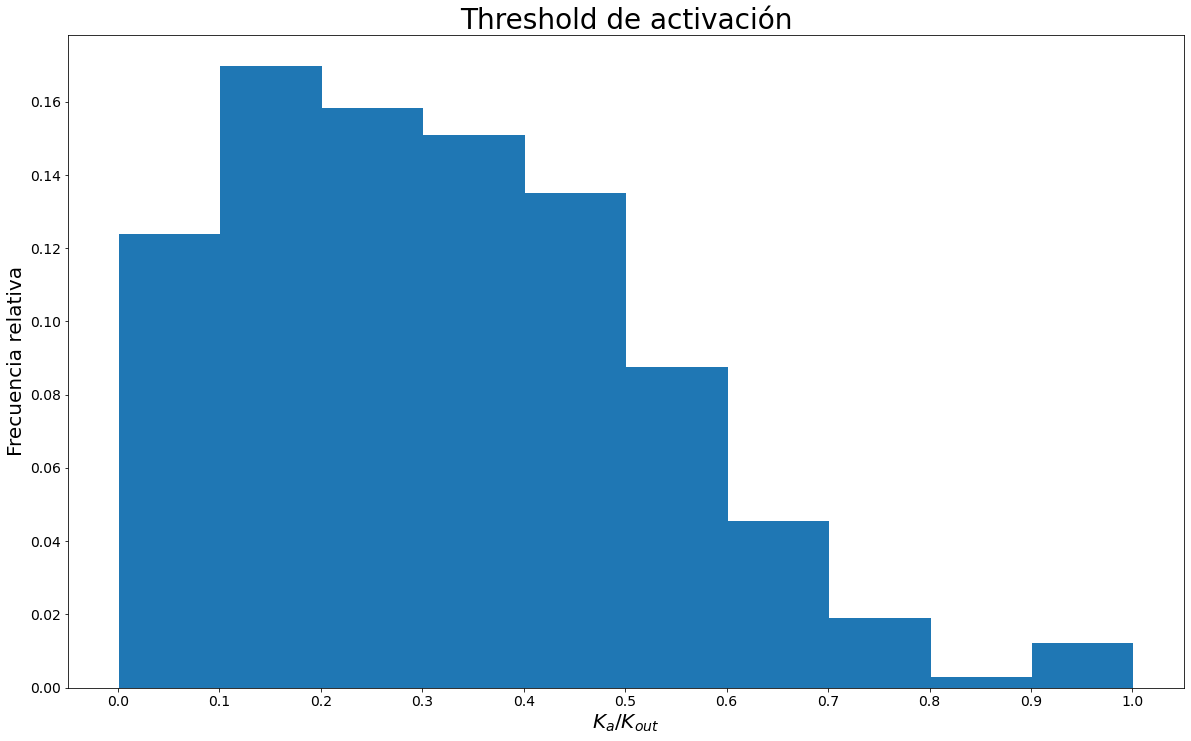

In [108]:
bins = np.arange(0.001, 1.05, 0.1)
bins2 = np.arange(0.00, 1.05, 0.1)


plt.figure(figsize=(20,12))
hist = plt.hist(activation_percentages, bins=bins, weights=np.ones_like(activation_percentages) / len(activation_percentages), log=False)
plt.xlabel("$K_a / K_{out}$", size=20)
plt.ylabel("Frecuencia relativa", size=20)
plt.xticks(bins2, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Threshold de activación", fontsize=28)

plt.show()

In [110]:
activation_percentages.count(0.8)

4697

In [109]:
hist

(array([0.12382747, 0.16970802, 0.1582863 , 0.15083051, 0.13512009,
        0.08750872, 0.04540448, 0.01895014, 0.00285241, 0.01220039]),
 array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
        6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00]),
 <BarContainer object of 10 artists>)

In [45]:
max(activation_percentages)

1.0

In [ ]:
activity_g.get_edge_data("23996", "253")["timestamp"]

In [ ]:
for u in activity_g.successors("223789"):
  print(u)

In [ ]:
activity_g.get_edge_data("1", "2523233")